In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone

plt.style.use('ggplot')
plt.rcParams["savefig.format"] = 'svg'
plt.rcParams['image.cmap'] = 'viridis'

np.random.seed(42)

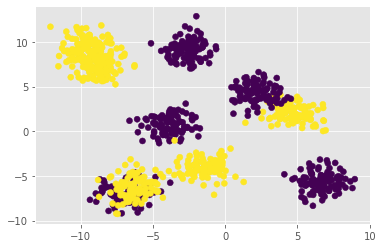

In [2]:
#n_samples=1000
#n_features=2
#x, y = make_blobs(n_samples=n_samples, n_features=n_features,
#                  centers=[[0, 1],[2, 3]], shuffle=False)

n_samples=1000
n_features=2
centers=10
x, blob_id = make_blobs(n_samples=n_samples, n_features=n_features,
                        centers=centers, shuffle=False)
y = blob_id%2

plt.scatter(x[:, 0], x[:, 1], c=y)

dataset_name = 'blobs_s_{}_f_{}_c_{}'.format(n_samples, n_features, centers)

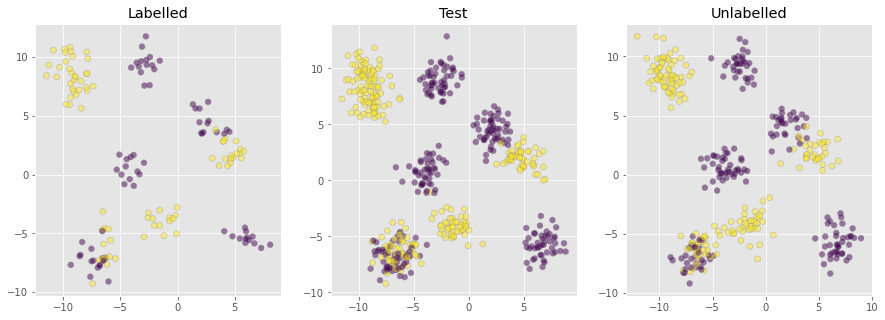

In [3]:
shuffle=True
dataset_name += '_iid' if shuffle else '_ood'
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=shuffle)
x_label, x_unlabel, y_label, y_unlabel = train_test_split(x_train, y_train, test_size=0.7, shuffle=False)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.set_title('Labelled')
ax.scatter(x_label[:,0], x_label[:,1], c=y_label, edgecolor='grey', alpha=0.5)
ax = fig.add_subplot(1, 3, 2)
ax.set_title('Test')
ax.scatter(x_test[:,0], x_test[:,1], c=y_test, edgecolor='grey', alpha=0.5)
ax = fig.add_subplot(1, 3, 3)
ax.set_title('Unlabelled')
ax.scatter(x_unlabel[:,0], x_unlabel[:,1], c=y_unlabel, edgecolor='grey', alpha=0.5)
#plt.scatter(x_unlabel[:,0], x_unlabel[:,1], c='white', edgecolors='black', alpha=0.5)
plt.savefig('semi_{}'.format(dataset_name))

In [4]:
# generation of a grid for later model exploration
# define bounds of the domain
min1, max1 = x[:, 0].min()-1, x[:, 0].max()+1
min2, max2 = x[:, 1].min()-1, x[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_contourmap(clf, x, y, ax=None, cmap='viridis'):
    if ax is None:
        fig, ax = plt.subplots()
    # make predictions for the grid
    yhat = clf.predict_proba(grid)[:,1]
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    im = ax.contourf(xx, yy, zz, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax)
    #ax.colorbar(label='$p(y=1|x)$')
    ax.scatter(x[:,0], x[:,1], c=y, edgecolors='grey',
                alpha=0.5, cmap=cmap)
    #plt.title('Accuarcy = {:0.3f}'.format(accuracy_score(y_l
    #plt.scatter(x_unlabel[:,0], x_unlabel[:,1], c='white', edgecolors='black',
    #            alpha=0.5)abel, clf.predict(x_label))))
    return ax

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

#model = LogisticRegression()
#model = SVC(kernel='rbf', probability=True)

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

from tensorflow.nn import softmax_cross_entropy_with_logits

def brier_loss(y_true, y_pred):    
    """ Computes weighted brier score for the given tensors    
    
    equivalent to:    
            w = class_weigths    
            N, C = y_true.shape    
            bs = 0    
            for n in range(N):    
                for c in range(C):    
                    bs += (y_pred[n, c] - y_true[n, c])**2    
            return bs/N    
    """    
    return tf.math.reduce_mean(
        tf.math.reduce_sum(
            tf.math.square(
                tf.math.subtract(y_pred, tf.cast(y_true, 'float32'))), axis=1))  



# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(50,  # output dim is 2, one score per each class
                activation='tanh',
                kernel_regularizer=L1L2(l1=0.0, l2=0.01),
                input_dim=n_features))  # input dimension = number of features your data has
    model.add(Dense(50,  # output dim is 2, one score per each class
                activation='tanh',
                kernel_regularizer=L1L2(l1=0.0, l2=0.01)))
    model.add(Dense(2,  # output dim is 2, one score per each class
                activation='softmax',
                kernel_regularizer=L1L2(l1=0.0, l2=0.01)))
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=10, verbose=0)

#model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

In [8]:
# from https://stackoverflow.com/questions/31947140/sklearn-labelbinarizer-returns-vector-when-there-are-2-classes
from sklearn.preprocessing import LabelBinarizer
import numpy as np

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((1-Y, Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 1], threshold)
        else:
            return super().inverse_transform(Y, threshold)


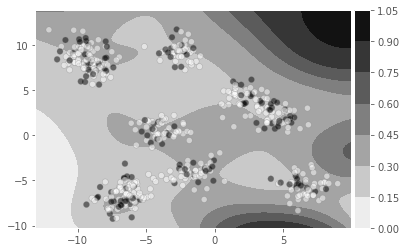

In [9]:
x_bgc = np.concatenate([x_label, x_unlabel])
y_bgc = np.concatenate([np.ones_like(y_label),
                        np.zeros_like(y_unlabel)])

from sklearn.utils import shuffle

x_bgc, y_bgc = shuffle(x_bgc, y_bgc)

from sklearn.svm import SVC
clf_bgc = SVC(kernel='rbf', probability=True)
#clf_bgc = clone(model)
#binarizer = MyLabelBinarizer()
#binarizer.fit(y_bgc)
#y_bgc_bin = binarizer.transform(y_bgc)
clf_bgc.fit(x_bgc, y_bgc)
    
plot_contourmap(clf_bgc, x_bgc, y_bgc, cmap='binary')
plt.savefig('{}_unl_vs_lab'.format(dataset_name))

In [10]:
from sklearn.preprocessing import label_binarize

def run_experiment(name='notweak', iterations=10):
    binarizer = MyLabelBinarizer()
    binarizer.fit(y_label)

    clf = clone(model)
    y_label_bin = binarizer.transform(y_label)
    clf.fit(x_label, y_label_bin)
    y_test_bin = binarizer.transform(y_test)
    clf.score(x_test, y_test_bin)

    performance_list = np.zeros(iterations)
    samples_list = np.ones(iterations)*(y_label.shape[0])
    plot_contourmap(clf, x_label, y_label)
    performance_list[0] = clf.score(x_test, y_test_bin)
    plt.title('Acc. = {:0.3f}'.format(performance_list[0]))
    plt.savefig('{}_{}_contourmap_it_0'.format(dataset_name, name))


    for i in range(1, iterations):
        plt.clf()
        predicted_probas = clf.predict_proba(x_unlabel)
        predicted_labels = np.argmax(predicted_probas, axis=1)

        if name in ['notweak', 'weak']:
            confidences = np.max(predicted_probas, axis=1)
            thresholds_sort_idx = np.argsort(-1*confidences)[:(1+int((i/iterations)*x_unlabel.shape[0]))]
            y_train_estimated = np.concatenate([y_label, predicted_labels[thresholds_sort_idx]])
            if name == 'notweak':
                y_train_estimated_bin = binarizer.transform(y_train_estimated)
            elif name == 'weak':
                y_train_estimated_bin = np.concatenate([y_label_bin, predicted_probas[thresholds_sort_idx]])
        elif name == 'bgc':
            confidences = clf_bgc.predict_proba(x_unlabel)[:,1]
            thresholds_sort_idx = np.argsort(-1*confidences)[:(1+int((i/iterations)*x_unlabel.shape[0]))]
            y_train_estimated = np.concatenate([y_label, predicted_labels[thresholds_sort_idx]])
            y_train_estimated_bin = np.concatenate(
                [y_label_bin,
                 predicted_probas[thresholds_sort_idx]*confidences[thresholds_sort_idx][:,np.newaxis]])
            
        x_train_estimated = np.concatenate([x_label, x_unlabel[thresholds_sort_idx]])
            
        clf = clone(model)
        clf.fit(x_train_estimated, y_train_estimated_bin)
        performance_list[i] = clf.score(x_test, y_test_bin)
        samples_list[i] = (y_train_estimated.shape[0])

        fig = plt.figure(figsize=(14, 5))
        ax = fig.add_subplot(1, 2, 1)
        plot_contourmap(clf, x_train_estimated, y_train_estimated, ax=ax)
        ax.set_title('Estimated labels. Acc. = {:0.3f}'.format(performance_list[i]))

        ax = fig.add_subplot(1, 2, 2)
        plot_contourmap(clf, x_test, y_test, ax=ax)
        ax.set_title('Ground truth labels. Acc. = {:0.3f}'.format(performance_list[i]))
        #fig.colorbar(ax=ax, label='$p(y=1|x)$')
        fig.savefig('{}_{}_contourmap_it_{}'.format(dataset_name, name, i))

    fig, ax = plt.subplots()
    ax.plot(samples_list, performance_list, 'o-')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('#samples ({} with ground truth)'.format(y_label.shape[0]))
    fig.savefig('{}_{}_evaluation_iteration'.format(dataset_name, name))

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/py

<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

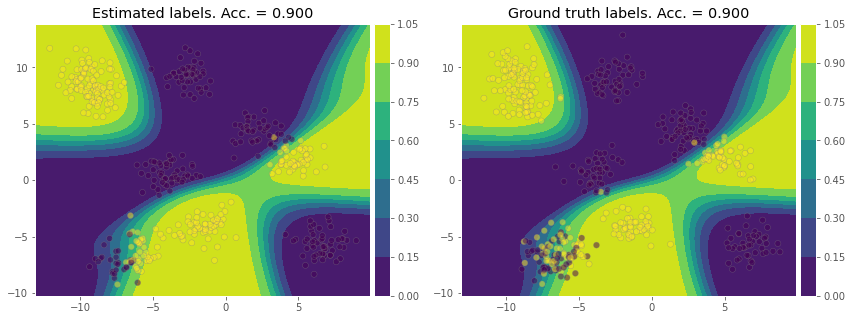

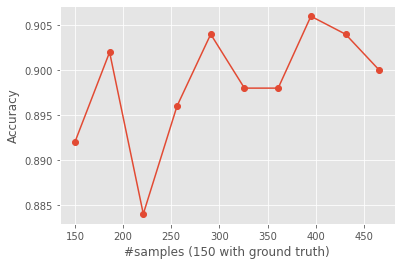

In [11]:
run_experiment(name='notweak')

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

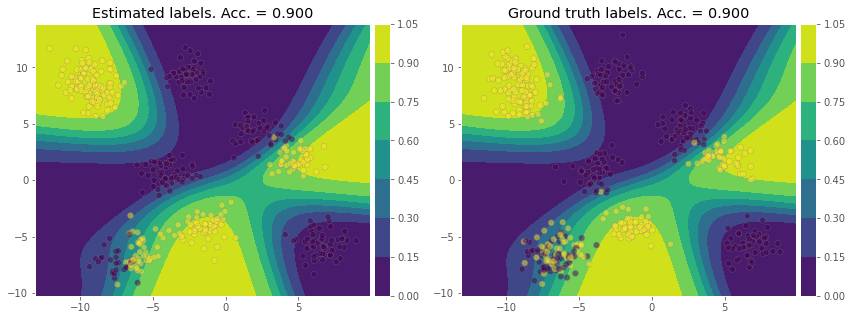

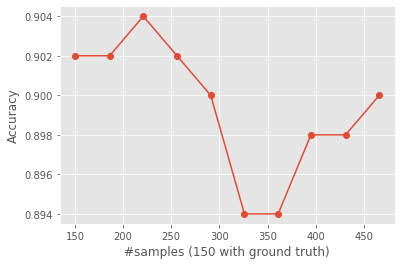

In [12]:
run_experiment(name='weak')

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/mp15688/git/machine_learning_concepts/venv/lib/py

<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

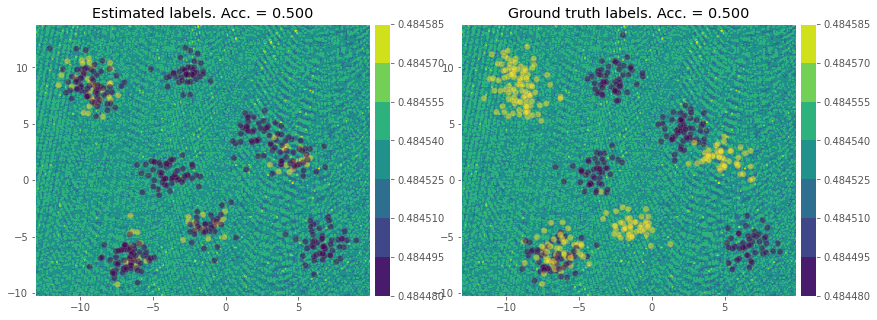

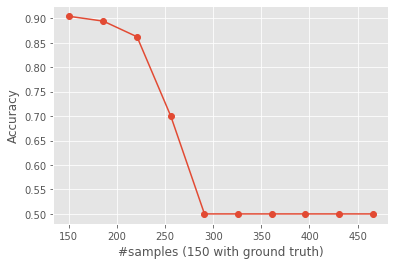

In [13]:
run_experiment(name='bgc')